In [46]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image
from scipy import stats

## Inserez les chemins vers le fichiers CSV:

In [47]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point'):
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['point35', 'point14_29_07_15', 'point15_29_07_15', 'Point50_131023', 'schema_dispositif_AvAv_23_07_15.png', 'point47_27_08_19', 'point13_29_07_15', 'point36_12_07_16', 'Point51_131023', 'point46_17_06_19', 'point34_27_06_16', 'point48_14_04_18']
['35', '14', '15', '47', '13', '36', '46', '34', '48']


In [48]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [49]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = []
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if (x.startswith('p') and x.endswith('.csv')) and not x.endswith('cleaned.csv') :
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    chemin_etalonnage = 'configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv'
    if os.path.exists(chemin_etalonnage):
        with open(chemin_etalonnage) as fichier :
            lignes = fichier.readlines()
            for l in lignes :
                if l.startswith('Intercept') :
                    dico['intercept'] = float(l[10:-2])
                if l.startswith('dU/dH') :
                    dico['dU/dH'] = float(l[6:-2])
                if l.startswith('dU/dT') :
                    dico['dU/dT'] = float(l[6:-2]) 
    data.append(dico)


In [50]:

#data[0]['pression']['Date Heure, GMT+01:00'].is_monotonic_increasing
#data[5]['numero']

In [51]:
# en faisant data[0] on a accès à toutes les informations du point 1
data[0]

{'numero': '35',
 'nom': 'point35',
 'date': '',
 'chemin': './raw_data/point35',
 'capteur': 'p508',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        # Date Heure, GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)  \
 0                                              0.58181   
 1                                              0.58059   
 2                                              0.57937   
 3                                              0.57937   
 4                                              0.57937   
 ..                                                 

# Est ce que les fichiers peuvent être utilisés ?

**Dans notre cas, nous prendrons ces solutions**

* S'il manque toutes les données du capteurs de pression ou l'étalonnage, nous déciderons que ce point est invalide.
* S'il manque une partie des données nous vérifierons que nous avons au mimimun 7 jours de données
* S'il manque plus de 2 capteurs de température, nous déciderons que ce point est invalide.

### Est ce que nous avons les données de l'étalonnage du capteur ?

In [52]:
for x in data :
    if not 'intercept' in x.keys() :
        print('le point '+ x['numero'] + ' n\'a pas d\'étalonnage, il n\'est pas valide')
        data.remove(x)

le point 50 n'a pas d'étalonnage, il n'est pas valide


### Est ce que nous avons des données pour le capteur de pression ?

In [53]:
for x in data :
    if x['pression'].empty :
        print('le point '+ x['numero'] + ' n\'a pas de données de pression, il n\'est pas valide')
        data.remove(x)

In [54]:
data[0]['pression']

,#,"Date Heure, GMT+02:00","Tension, V (LGR S/N: 10117169, SEN S/N: 10117169)","Temp., °C (LGR S/N: 10117169, SEN S/N: 10117169)"
0,1,07/23/15 02:00:00 PM,0.58181,18.129
1,2,07/23/15 02:15:00 PM,0.58059,18.081
2,3,07/23/15 02:30:00 PM,0.57937,18.033
3,4,07/23/15 02:45:00 PM,0.57937,18.224
4,5,07/23/15 03:00:00 PM,0.57937,18.247
...,...,...,...,...
558,559,07/29/15 09:30:00 AM,0.54884,14.194
559,560,07/29/15 09:45:00 AM,0.54884,14.242
560,561,07/29/15 10:00:00 AM,0.54884,14.194
561,562,07/29/15 10:15:00 AM,0.54884,14.625


### On modifie les nom des colonnes du dataframe

In [55]:
# pour les températures
for x in data :
    # on supprime les colonnes qui ne servent à rien
    for i in x['temperature'].columns :
        if not( i.startswith(('Date', 'dates', 'temp','Temp'))) :
            del x['temperature'][i]
    if x['numero'] == '36':
        print(x['temperature'].columns[-1])
        del x['temperature'][x['temperature'].columns[-1]]
    for i in x['pression'].columns :
        if not( i.startswith(('Date', 'dates', 'Tension', 'tension', 'pressure', 'temp', 'Temp'))) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    print(colonnesT)
    print(x['temperature'].columns)
    print(x['numero'])
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP
    

['dates', 'Temp_profondeur_10', 'Temp_profondeur_20', 'Temp_profondeur_30', 'Temp_profondeur_40']
Index(['Date Heure, GMT+02:00',
       'Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154)',
       'Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).1',
       'Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).2',
       'Temp., °C (LGR S/N: 10117154, SEN S/N: 10117154).3'],
      dtype='object')
35
['dates', 'Temp_profondeur_10', 'Temp_profondeur_20', 'Temp_profondeur_30', 'Temp_profondeur_40']
Index(['Date Heure, GMT+02:00',
       'Temp., °C (LGR S/N: 10117161, SEN S/N: 10117161)',
       'Temp., °C (LGR S/N: 10117161, SEN S/N: 10117161).1',
       'Temp., °C (LGR S/N: 10117161, SEN S/N: 10117161).2',
       'Temp., °C (LGR S/N: 10117161, SEN S/N: 10117161).3'],
      dtype='object')
14
['dates', 'Temp_profondeur_7', 'Temp_profondeur_22', 'Temp_profondeur_37', 'Temp_profondeur_52']
Index(['Date Heure, GMT+02:00',
       'Temp. °C (LGR S/N: 10445474, SEN S/N: 10445474)',
       'Temp. °C 

In [56]:
# notamment la température et la pression
data[0]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 12:30:00 PM,210.450,31.484,31.001,223.886
1,07/23/15 12:45:00 PM,206.695,17.986,18.390,537.327
2,07/23/15 01:00:00 PM,206.695,18.152,18.461,537.327
3,07/23/15 01:15:00 PM,208.536,17.867,18.176,537.327
4,07/23/15 01:30:00 PM,208.536,17.915,18.295,537.327


## Conversion de valeurs de tension a differance de charge

In [57]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data[0]['pression']

,dates,tension,temperature_stream,dH
0,07/23/15 02:00:00 PM,0.58181,18.129,0.085770
1,07/23/15 02:15:00 PM,0.58059,18.081,0.085981
2,07/23/15 02:30:00 PM,0.57937,18.033,0.086192
3,07/23/15 02:45:00 PM,0.57937,18.224,0.085898
4,07/23/15 03:00:00 PM,0.57937,18.247,0.085863
...,...,...,...,...
558,07/29/15 09:30:00 AM,0.54884,14.194,0.095526
559,07/29/15 09:45:00 AM,0.54884,14.242,0.095452
560,07/29/15 10:00:00 AM,0.54884,14.194,0.095526
561,07/29/15 10:15:00 AM,0.54884,14.625,0.094863


### On enlève les valeurs Nan

In [58]:
for x in data :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [59]:
from dateutil import parser

# Conversion dans le bon format date
for x in data:
    x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
    x['temperature']['dates'] = x['temperature']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))
#    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='mixed')
#    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='mixed')

<ipython-input-59-06f3f1cb27e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pression']['dates'] = x['pression']['dates'].apply(lambda x: parser.parse(x).strftime('%d-%m-%Y %H:%M'))


In [60]:
data[0]['pression'].head(5)

,dates,tension,temperature_stream,dH
0,23-07-2015 14:00,0.58181,18.129,0.085770
1,23-07-2015 14:15,0.58059,18.081,0.085981
2,23-07-2015 14:30,0.57937,18.033,0.086192
3,23-07-2015 14:45,0.57937,18.224,0.085898
4,23-07-2015 15:00,0.57937,18.247,0.085863


In [61]:
for x in data :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [138]:
# Fonction pour calculer les statistiques et les valeurs IQR
def calculate_quantiles_iqr(df, column_name):
    median = df[column_name].median()
    # Calculer les quantiles Q1 et Q3 pour la colonne spécifiée
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    
    # Calculer l'IQR
    iqr = q3 - q1
    minimum = q1 - 1.5 * iqr  # Valeur minimale (|- dans la boîte à moustaches)
    maximum = q3 + 1.5 * iqr  # Valeur maximale (-| dans la boîte à moustaches)
    return median, q1, q3, iqr, minimum, maximum

# Fonction pour obtenir un texte décrivant les statistiques de base
def get_iqr_text(df, col_name):
    # Calcul des statistiques de base
    median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Création du texte
    text = f"médiane={median:.2f}, Q1={q1:.2f}, Q3={q3:.2f}, IQR={iqr:.2f}, minimum={minimum:.2f}, maximum={maximum:.2f}"
    return text

# Fonction pour supprimer les valeurs aberrantes
def remove_outliers(df, col_name):
    # Obtention des limites pour les valeurs non aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df, col_name)
    
    # Sélection des lignes avec des valeurs non aberrantes
    df_out = df.loc[(df[col_name] > minimum) & (df[col_name] < maximum)]
    return df_out

# Fonction pour compter les valeurs aberrantes
def count_outliers(df_in, col_name):
    # Obtention des limites pour les valeurs aberrantes
    _, _, _, _, minimum, maximum = calculate_quantiles_iqr(df_in, col_name)
    
    # Sélection des lignes avec des valeurs aberrantes
    df_outliers = df_in.loc[(df_in[col_name] <= minimum) | (df_in[col_name] >= maximum)]
    
    # Comptage des valeurs aberrantes
    num_outliers = df_outliers.shape[0]
    return num_outliers

# Fonction pour générer un graphique de boîte à moustaches
def box_and_whisker(df_in, col_name):
    # Obtention du texte décrivant les statistiques
    title = get_iqr_text(df_in, col_name)
    
    # Tracé du graphique de boîte à moustaches
    sns.boxplot(df_in[col_name])
    plt.title(title)
    plt.show()

# Fonction pour tracer les données avec et sans valeurs aberrantes
def plot_data_with_and_without_outliers(df, col_name):
    plt.figure(figsize=(12, 6))
    
    # Tracé des données brutes
    plt.subplot(1, 2, 1)
    plt.title("Données brutes")
    sns.boxplot(df[col_name])
    
    # Tracé des données sans valeurs aberrantes
    plt.subplot(1, 2, 2)
    plt.title("Données sans valeurs aberrantes")
    df_cleaned = remove_outliers(df, col_name)
    sns.boxplot(df_cleaned[col_name])
    
    plt.tight_layout()
    plt.show()


In [139]:
def nb_val_abberantes(capteur_riviere, capteur_ZH):
    df = capteur_ZH.copy()
    df["temperature_stream"] = capteur_riviere[["temperature_stream"]]
    df["dH"] = capteur_riviere[["dH"]]
    for column in df.columns:
        if column != "dates":
            print(f"Analyse pour la colonne : {column}")
            #plot_data_with_and_without_outliers(df, column)
            #print(f"Nombre de valeurs aberrantes : {count_outliers(df, column)}\n")
            
    # Créer un DataFrame vide pour stocker les données traitées
    df_processed = df[["dates"]].copy()

    # Boucler à travers chaque colonne de df
    for column_name in df.columns:
        if column_name == "dates":
            continue  # Ignorer la colonne des dates
            
        # Traiter la colonne et stocker les données traitées dans df_processed
        median, q1, q3, iqr, minimum, maximum = calculate_quantiles_iqr(df, column_name)
        df_processed[f"{column_name}"] = remove_outliers(df, column_name)[column_name]
        
    # Afficher les statistiques des données traitées
    print(df_processed.describe())
    return df, df_processed

In [140]:
for x in data :
    df_processed  = nb_val_abberantes(x['pression'], x['temperature'])[1]
    df_processed = df_processed.dropna(axis = 0, how='any')
    x['pression2'] = df_processed[['dates', 'temperature_stream', 'dH']].copy()
    x['temperature2'] = df_processed.drop(columns = [ 'temperature_stream','dH']).copy()

Analyse pour la colonne : Temp_profondeur_10
Analyse pour la colonne : Temp_profondeur_20
Analyse pour la colonne : Temp_profondeur_30
Analyse pour la colonne : Temp_profondeur_40
Analyse pour la colonne : temperature_stream
Analyse pour la colonne : dH
       Temp_profondeur_10  Temp_profondeur_20  Temp_profondeur_30  \
count          562.000000          566.000000          566.000000   
mean            16.147274           15.976855           16.343615   
std              1.071275            0.923462            0.836122   
min             14.050000           14.026000           14.146000   
25%             15.127000           15.127000           15.557000   
50%             15.724000           15.461000           16.022000   
75%             17.171000           16.868000           17.130000   
max             18.319000           18.152000           18.461000   

       Temp_profondeur_40  temperature_stream          dH  
count          562.000000          562.000000  562.000000  
mean

In [141]:
df_processed.head()

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40,temperature_stream,dH
0,14-04-2018 13:45,13.124,12.467,12.022,11.821,13.778,-0.281872
1,14-04-2018 14:00,13.081,12.388,11.910,11.686,13.660,-0.254874
2,14-04-2018 14:15,13.064,12.370,11.874,11.637,13.595,-0.267265
3,14-04-2018 14:30,13.052,12.370,11.862,11.616,13.538,-0.257211
4,14-04-2018 14:45,13.038,12.378,11.859,11.605,13.401,-0.271494


In [142]:
for x in data :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

In [143]:
# on met à jour la date de début de la mesure, la date de fin et la période
from datetime import datetime

for x in data :
    x['dateDebut'] = datetime.strptime(x['pression2']['dates'].iloc[0], '%d-%m-%Y %H:%M')
    x['dateFin'] = datetime.strptime(x['pression2']['dates'].iloc[x['pression2']['dates'].shape[0]-1], '%d-%m-%Y %H:%M')
    x['periode'] = x['dateFin'] - x['dateDebut']

In [144]:
for x in data :
    x['pression2']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
    x['temperature2']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
    x['pression']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
    x['temperature']['dates'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))


### Est ce que nous avons au minimum 3 jours de données ?

In [145]:
for x in data :
    if x['periode'].days <= 3 :
        print('le point ' + x['numero'] + ' n\'est pas valide car sa période est de seulement ' + str(x['periode'])[0] +' jours')
        data.remove(x)

le point 15 n'est pas valide car sa période est de seulement 0 jours


### Création du fichier `info.txt`

In [146]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

In [147]:
data[0]['temperature2']

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
11,12-07-2016 13:45,15.151,14.050,14.122,14.170
12,12-07-2016 14:00,15.151,14.026,14.074,14.122
13,12-07-2016 14:15,15.199,14.002,14.050,14.098
14,12-07-2016 14:30,15.223,14.002,14.026,14.074
15,12-07-2016 14:45,15.270,14.002,14.002,14.074
...,...,...,...,...,...
1832,31-07-2016 13:00,14.601,13.858,13.882,14.170
1833,31-07-2016 13:15,14.625,13.858,13.882,14.170
1834,31-07-2016 13:30,14.697,13.858,13.858,14.170
1835,31-07-2016 13:45,14.745,13.882,13.858,14.170


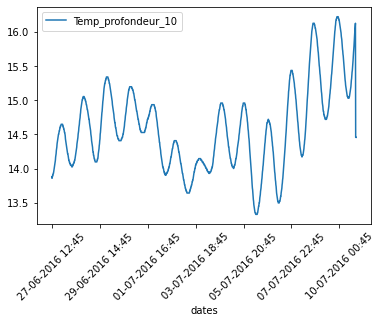

In [72]:
i = 6
print(data[i]['numero'])
#plt.plot(data[i]['pression']['dates'], data[i]['pression']['dH']*150, color = 'blue')
data[i]['temperature'][:-1].plot(x='dates', y=['Temp_profondeur_10', 'Temp_profondeur_20', 'Temp_profondeur_30', 'Temp_profondeur_40'], rot=45, kind='line')
data[i]['temperature2'][34:].plot(x='dates', y=['Temp_profondeur_10', 'Temp_profondeur_20', 'Temp_profondeur_30', 'Temp_profondeur_40'], rot=45, kind='line')

#plt.plot(data[i]['pression']['dates'], data[i]['pression']['temperature_stream'], color = 'red')
plt.show()

14, 35, 46, 

In [73]:
data[i]['pression']['dates'].is_monotonic_increasing

False

In [74]:
### Création du fichier `data.csv`
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_pression_cleaned.csv') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_pression_cleaned.csv')
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_temperature_cleaned.csv') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_temperature_cleaned.csv')
    
    with open(x['chemin'] + '/point' + x['numero'] + '_pression_cleaned.csv', 'w') as fichier:
        x['pression2'].to_csv(fichier, index=False)
    with open(x['chemin'] + '/point' + x['numero'] + '_temperature_cleaned.csv', 'w') as fichier:
        x['temperature2'].to_csv(fichier, index=False)
